# Proyecto PixelSounds

### ¿Qué es PixelSounds?

PixelSounds es el resultado al que hemos llegado entre todos los participantes de este grupo al querer responder a nuestra manera la misma cuestión: si es posible una compatibilidad entre las imágenes y el audio. Los métodos y resultados que hemos desarrollado no tienen por qué ser ni los únicos ni los correctos, son una de las posibles interpretaciones que se pueden escoger. El proceso ha sido un conjunto de probar cosas nuevas, añadir algo a ver qué podría pasar y ver la evolución de una idea mientras seguíamos nuestra curiosidad por desarrollar conocimientos.

Como es tradición y porque ya toca enseñar el trabajo que se ha desarrollado, lo primero es importar los paquetes necesarios.

In [1]:
import pixelsounds as ps
import cv2
import os
import numpy as np
import librosa
import warnings
import scipy.fftpack as fft
import matplotlib.pyplot as plt
import random
import soundfile as sf
from scipy.ndimage import gaussian_filter1d, median_filter, gaussian_filter
from scipy import signal
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import vozyaudio as vz
np.float = float

## 1. De la imagen al audio

Si de alguna forma quisiéramos "escuchar" una imagen hay unos cuantos acercamientos posibles. Uno bastante inmediato es considerar la propia imagen como el espectrograma de un audio y entonces realizar la ISTFT para obtener el sonido correspondiente. Es algo que se puede ver en YouTube en algún que otro vídeo y no está mal, pero no parece tener mucha más gracia y el objetivo es intentar cosas nuevas y originales.

Planteando este proyecto la primera idea que surgió fue, que ya que hay tantas incógnitas y caminos posibles para elegir, una forma de avanzar sería extraer la mayor cantidad de características de una imagen para tener algo desde donde partir.

### 1.1. Extracción de características de la imagen

Lo primero que necesitamos es una imagen de prueba. Puedes elegir la que quieras y poner la ruta indicada para acceder al archivo o elegir alguna de las imágenes de prueba que proporcionamos en la carpeta "images".

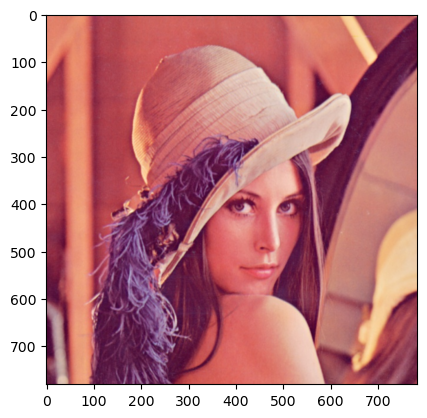

In [7]:
img_og = "images/lena.png" # Ruta a la imagen
img = cv2.imread(img_og)   
img = img[:,:,::-1]     # Como estamos usando OpenCV, donde las imágenes a color se guardan como GBR y no RGB, hay que invertir el orden de los canales.

plt.imshow(img);        # Mostrar la imagen

#### 1.1.1. Separación de canales de color

A efectos prácticos una señal de audio solo es una serie de valores discretos en un vector. Una imagen no es más que lo mismo con más dimensiones, y en el caso de una a color, puede que incluso con demasiadas. Para hacernos la vida más sencilla podemos separar la imagen en distintos canales de color. PixelSounds dispone de funciones para esta tarea, podemos recibir los canales RGB e YcbCr por si queremos trabajar con ambas representaciones.

In [9]:
# Tan solo son funciones de OpenCV modificadas para recibir los canales de una forma más práctica.
r,g,b   = ps.extract_rgb(img_og)
y,cb,cr = ps.extract_ycbcr(img_og)

Podemos visualizar si queremos estas imágenes.

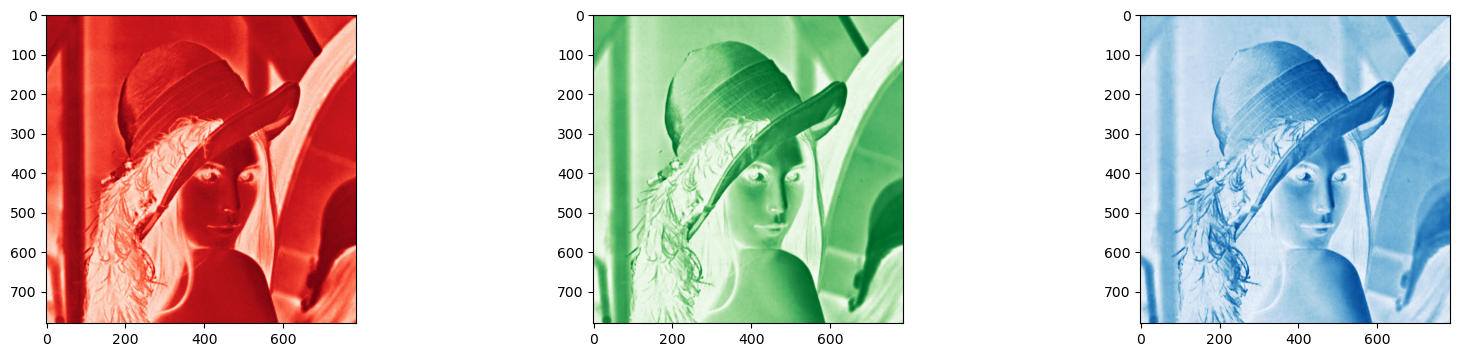

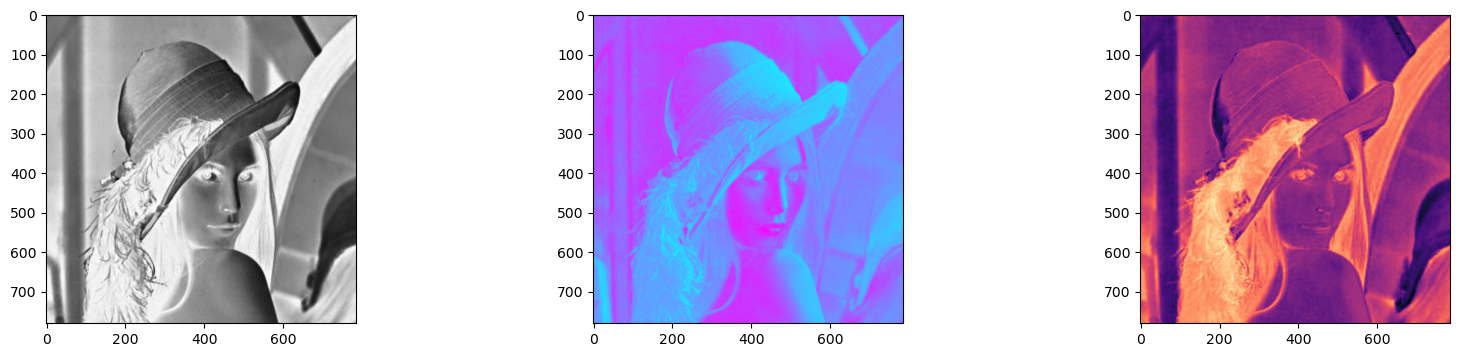

In [11]:
plt.figure(figsize=(20, 4))
plt.subplot(131)
_ = plt.imshow(r, cmap="Reds")
plt.subplot(132)
_ = plt.imshow(g, cmap="Greens")
plt.subplot(133)
_ = plt.imshow(b, cmap="Blues")

plt.figure(figsize=(20, 4))
plt.subplot(131)
_ = plt.imshow(y, cmap="Greys")
plt.subplot(132)
_ = plt.imshow(cb, cmap="cool")
plt.subplot(133)
_ = plt.imshow(cr, cmap="magma")

#### 1.1.2. Histograma

El histograma en imágenes es una herramienta muy útil para ver cómo de repartidos están los niveles de intensidad por píxel en cada canal. De normal puede ser útil para ver el nivel de contraste o si está sub- o sobre- expuesta. Sin embargo, ¿cómo podríamos aprovecharlo para nuestro objetivo? 

Una idea podía ser crear señales de audio a partir de este, ya que algunos histogramas de imágenes tienen parecido con algunos de audio, aunque salvando ciertas diferencias. Se pueden ver picos máximos parecidos a los que aparecen sobre el nivel 0 en audio y algunas distribuciones podrían parecerse a la geométrica, sin embargo esta es una operación no invertible, y aunque nos pueda dar información sobre los niveles que podría tener el sonido, no sabemos cómo distribuir estos.

No habría que abandonar al 100% este camino, pero habría que darle una vuelta para poder aprovecharlo.

Otra posibilidad es, y tendrá más futuro, poder asociar el uso de efectos a ciertas partes o toda la señal sonora en base al histograma de alguno o todos sus canales de color. Por ejemplo, si se dividiera el histograma del brillo de la imagen en ciertos rangos y donde cayera cierto porcentaje de píxeles en este aplicar de una forma u otra ciertos efectos.

Vamos a ver cómo es el histograma de nuestra imagen, esto nos puede ayudar en el futuro para elegir un canal con el que queramos trabajar.

In [15]:
hist_r  = ps.histograma(r)
hist_g  = ps.histograma(g)
hist_b  = ps.histograma(b)
hist_y  = ps.histograma(y)
hist_cb = ps.histograma(cb)
hist_cr = ps.histograma(cr)

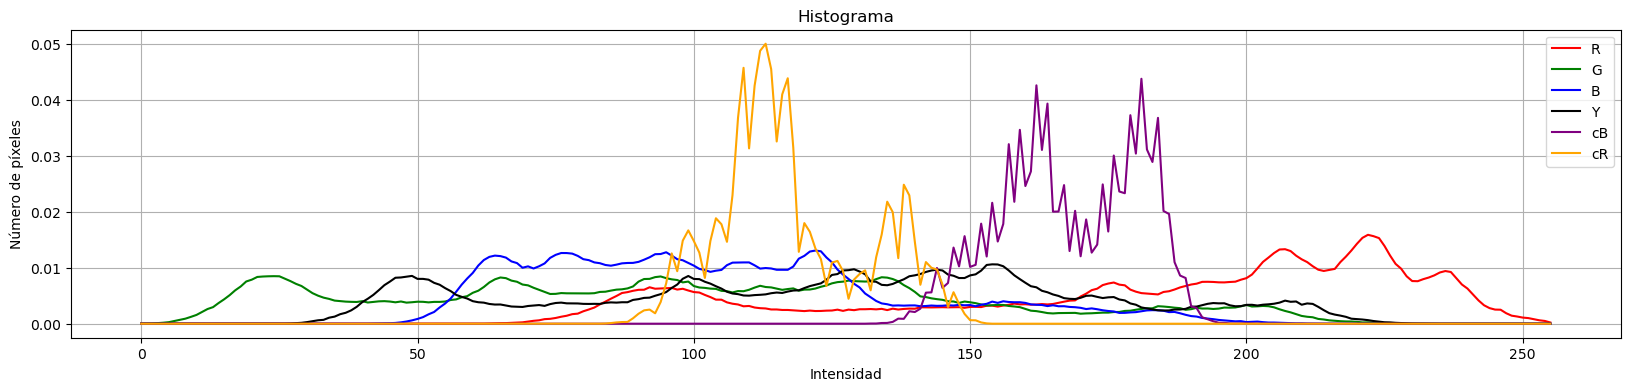

In [16]:
intensidad = range(0,256)
plt.figure(figsize=(20, 4))
plt.plot(intensidad,hist_r,"r",label="R")
plt.plot(intensidad,hist_g,"g",label="G")
plt.plot(intensidad,hist_b,"b",label="B")
plt.plot(intensidad,hist_y,"k",label="Y")
plt.plot(intensidad,hist_cb,"purple",label="cB")
plt.plot(intensidad,hist_cr,"orange",label="cR")
plt.title('Histograma')
plt.xlabel('Intensidad')
plt.ylabel('Número de píxeles')
plt.legend(loc="upper right")
plt.grid()
plt.show()

#### 1.1.3. Gradiente

Si uno quiere trabajar con imágenes en campos como la detección de objetos el gradiente, que se puede tomar como la derivada de la imagen, es una operación útil ya que representa los cambios entre intensidades, los bordes de las figuras básicamente. Aunque no parezca tener relación directa con el audio puede ser interesante plantearse cómo se podría usar.

In [17]:
gradiente_r  = ps.gradiente(r)
gradiente_g  = ps.gradiente(g)
gradiente_b  = ps.gradiente(b)
gradiente_y  = ps.gradiente(y)
gradiente_cb = ps.gradiente(cb)
gradiente_cr = ps.gradiente(cr)

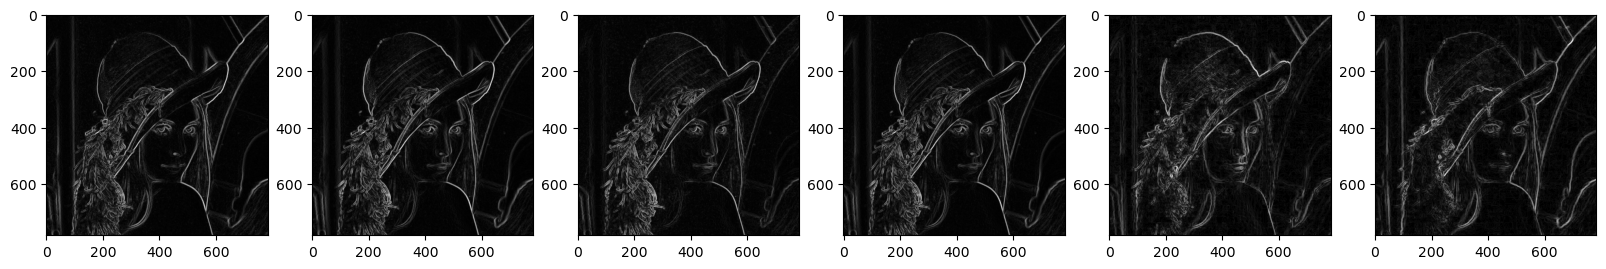

In [18]:
plt.figure(figsize=(20, 7))
plt.subplot(161)
_ = plt.imshow(gradiente_r, cmap="Greys")
plt.subplot(162)
_ = plt.imshow(gradiente_g, cmap="Greys")
plt.subplot(163)
_ = plt.imshow(gradiente_b, cmap="Greys")
plt.subplot(164)
_ = plt.imshow(gradiente_y, cmap="Greys")
plt.subplot(165)
_ = plt.imshow(gradiente_cb, cmap="Greys")
plt.subplot(166)
_ = plt.imshow(gradiente_cr, cmap="Greys")